In [1]:
from dataset import download_dataset, generate_taxonomy_dataframe, BeetleSet, TransformsDataset, stratified_split, generate_labels_dict
from models import SimpleMultiTaskModel, SequentialMultiTaskModel
from train import fit, test

import torch
from torch.utils.data import Subset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
import torchvision
import numpy as np

import json
from pathlib import Path

# Global parameters

In [2]:
BEETLENET_MEAN = np.array([0.8442649, 0.82529384, 0.82333773], dtype=np.float32)
BEETLENET_STD = np.array([0.28980458, 0.32252666, 0.3240354], dtype=np.float32)
BEETLENET_AVERAGE_SHAPE = (224, 448)
default_transforms = Compose([Resize(BEETLENET_AVERAGE_SHAPE), ToTensor(), Normalize(BEETLENET_MEAN, BEETLENET_STD)])
batch_size = 64
num_workers = 4
num_epochs = 200
seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Download dataset, generate potentially modified taxonomy file and set up dataset class

In [3]:
download_dataset()
root = '../output/msc-thesis-22/'
taxa = ['subfamily', 'tribe', 'genus', 'species']
model_name = 'simple_multi_model_resnet18' + '_' + '_'.join(taxa) #TODO get a better representation
Path(root + model_name).mkdir(parents=True, exist_ok=True)
dataframe = generate_taxonomy_dataframe('data/beetles/taxonomy.csv', root + model_name + '/taxonomy-modified.csv', drop_min=9)
beetleset = BeetleSet(csv_path=root + model_name + '/taxonomy-modified.csv', taxa=taxa)


# Split dataset and create dataloaders

In [4]:
train_idxs, val_idxs, test_idxs = stratified_split_equal(beetleset, seed = seed)
train_set = TransformsDataset(Subset(beetleset, train_idxs), transform = default_transforms)
val_set = TransformsDataset(
    Subset(beetleset, val_idxs), transform=default_transforms)
test_set = TransformsDataset(
    Subset(beetleset, test_idxs), transform=default_transforms)
dataset_sizes = {}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(val_set)
dataset_sizes['test'] = len(test_set)

dataloaders = {}
dataloaders['train'] = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory= True)
dataloaders['val'] = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory= True)
dataloaders['test'] = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory= True)

# Instantiate model and fit

In [5]:
labels_per_taxon = [len(beetleset.labels_dict[taxon]) for taxon in taxa]
model = SimpleMultiTaskModel(torchvision.models.resnet18(False), labels_per_taxon).to(device)

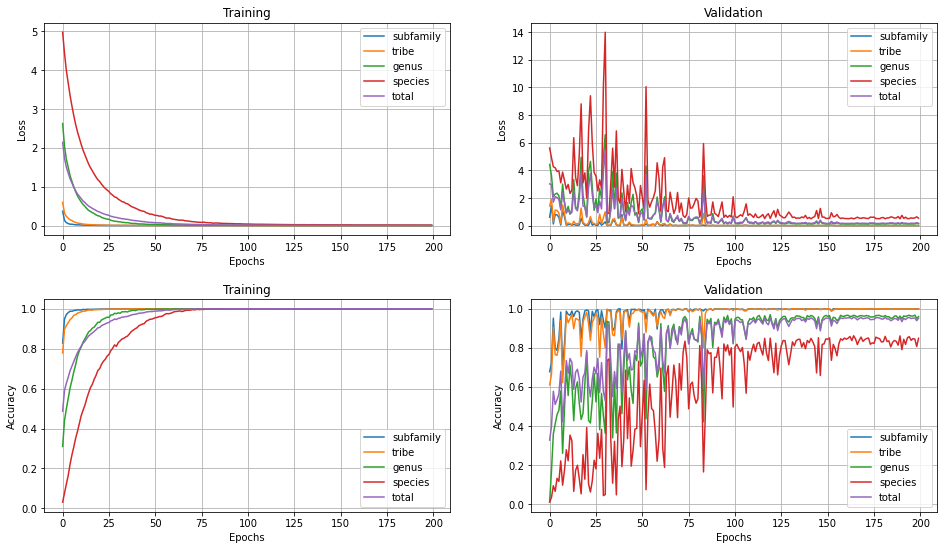

Training complete in 59m 55s
----------
Best validation epoch:  189
Best validation accuracy: 0.955517
Best validation loss: 0.152364



In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
if __name__ == '__main__':
    model, metrics = fit(model, criterion, optimizer, scheduler, dataloaders, taxa, 
                                        dataset_sizes, device = device, num_epochs = num_epochs, plot_path = root + model_name + '/metrics')

# Test model and save its metrics and weights

In [7]:
test_metrics = test(model, criterion, dataloaders['test'], device, dataset_sizes, taxa)
for taxon in taxa + ['total']:
    metrics[taxon]['test'] = test_metrics[taxon]

In [8]:
torch.save(model.state_dict(), root + model_name + '/state_dict.pt')

with open(root + model_name + '/metrics.json', 'w') as file:
    json.dump(metrics, file, indent = 4)